<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
df = pd.read_csv('seguimientocovidpositivo.csv')

TRATAMIENTO DE DATOS

In [24]:
# Limpieza de datos
df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce')

# Manejo de valores faltantes
df['Cantidad'] = df['Cantidad'].fillna(df.groupby('Región')['Cantidad'].transform('median'))

# Convertir fecha a datetime y extraer características temporales
df['Fecha inicio'] = pd.to_datetime(df['Fecha inicio'])
df['Mes'] = df['Fecha inicio'].dt.month
df['Semana'] = df['Fecha inicio'].dt.isocalendar().week
df['Dia_semana'] = df['Fecha inicio'].dt.dayofweek

# Codificación de variables categóricas
le = LabelEncoder()
df['Región_encoded'] = le.fit_transform(df['Región'])

ANÁLISIS EXPLORATORIO

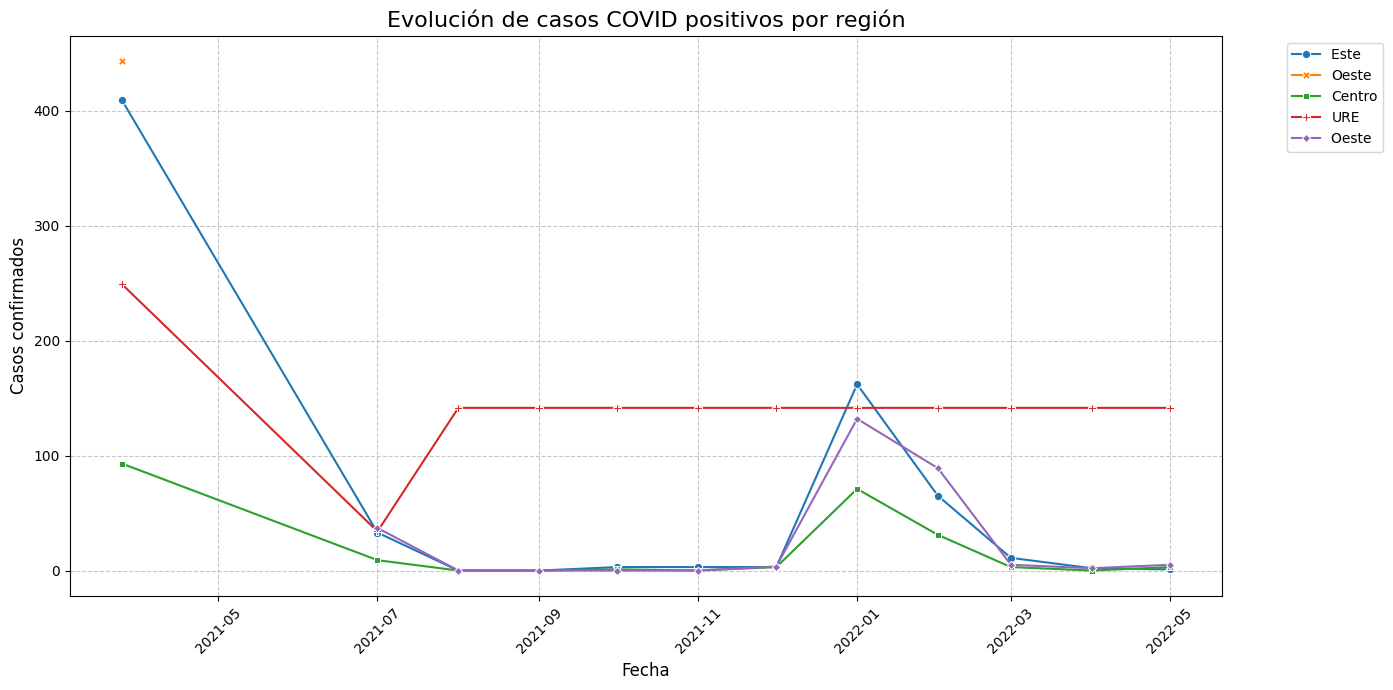

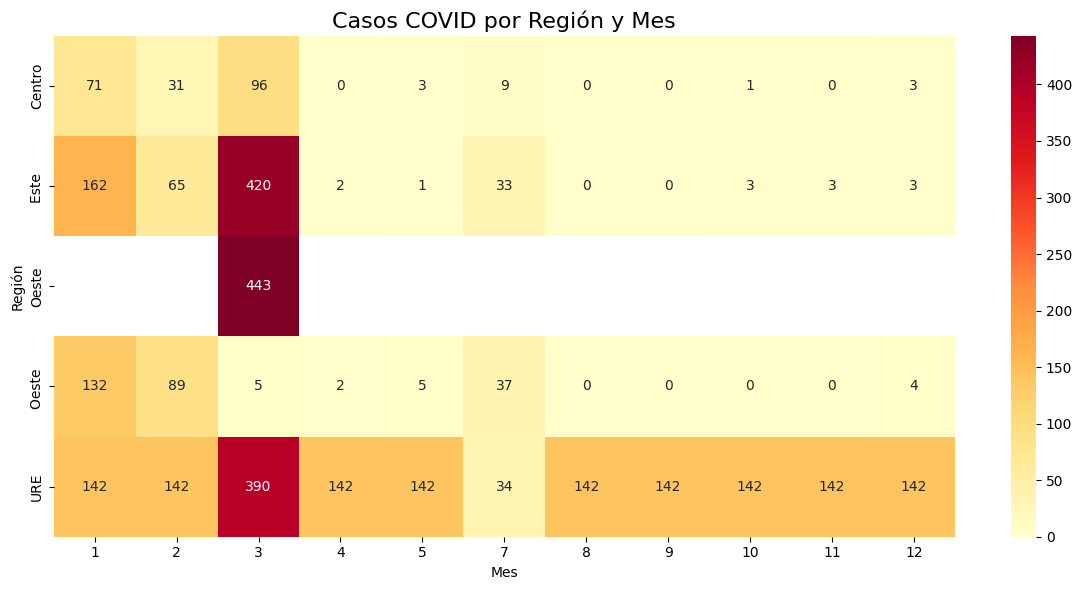

In [25]:
# Gráfico de líneas por región con mejoras
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Fecha inicio', y='Cantidad', hue='Región',
             style='Región', markers=True, dashes=False, ci=None)
plt.title('Evolución de casos COVID positivos por región', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos confirmados', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Heatmap de casos por región y mes
pivot_table = df.pivot_table(values='Cantidad', index='Región', columns='Mes', aggfunc='sum')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Casos COVID por Región y Mes', fontsize=16)
plt.tight_layout()
plt.show()

MODELO DE PREDICCIÓN


MAE: 8.86
RMSE: 12.31


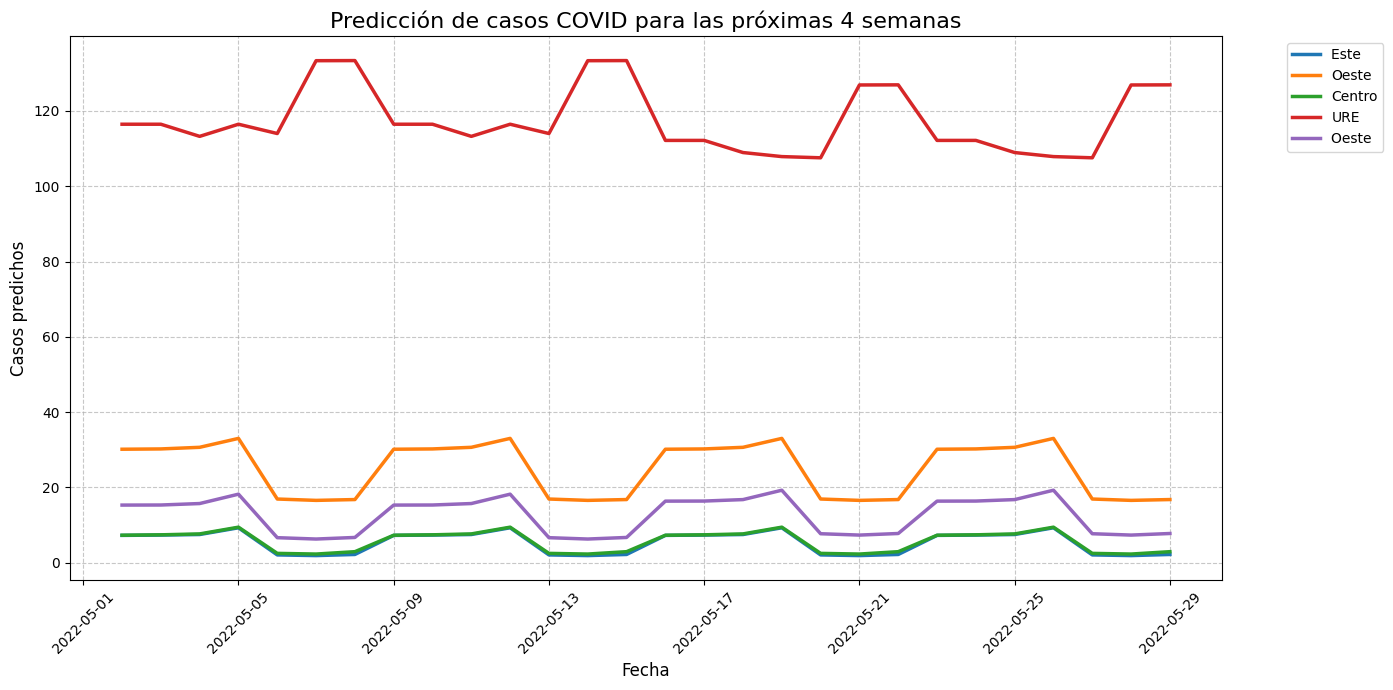

In [26]:
# Preparación de datos para modelo
features = ['Región_encoded', 'Mes', 'Semana', 'Dia_semana']
X = df[features]
y = df['Cantidad']

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = rf_model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Predicciones para las próximas 4 semanas
last_date = df['Fecha inicio'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=28, freq='D')

future_data = pd.DataFrame({
    'Fecha inicio': future_dates,
    'Mes': future_dates.month,
    'Semana': future_dates.isocalendar().week,
    'Dia_semana': future_dates.dayofweek
})

# Predecir para cada región
regions = df['Región'].unique()
predictions = []

for region in regions:
    region_code = le.transform([region])[0]
    temp_df = future_data.copy()
    temp_df['Región_encoded'] = region_code
    temp_df['Prediccion'] = rf_model.predict(temp_df[features])
    temp_df['Región'] = region
    predictions.append(temp_df)

predictions_df = pd.concat(predictions)

# Visualización de predicciones
plt.figure(figsize=(14, 7))
for region in regions:
    region_data = predictions_df[predictions_df['Región'] == region]
    sns.lineplot(data=region_data, x='Fecha inicio', y='Prediccion', label=region, linewidth=2.5)

plt.title('Predicción de casos COVID para las próximas 4 semanas', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos predichos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


MODELO ARIMA (Series Temporales)


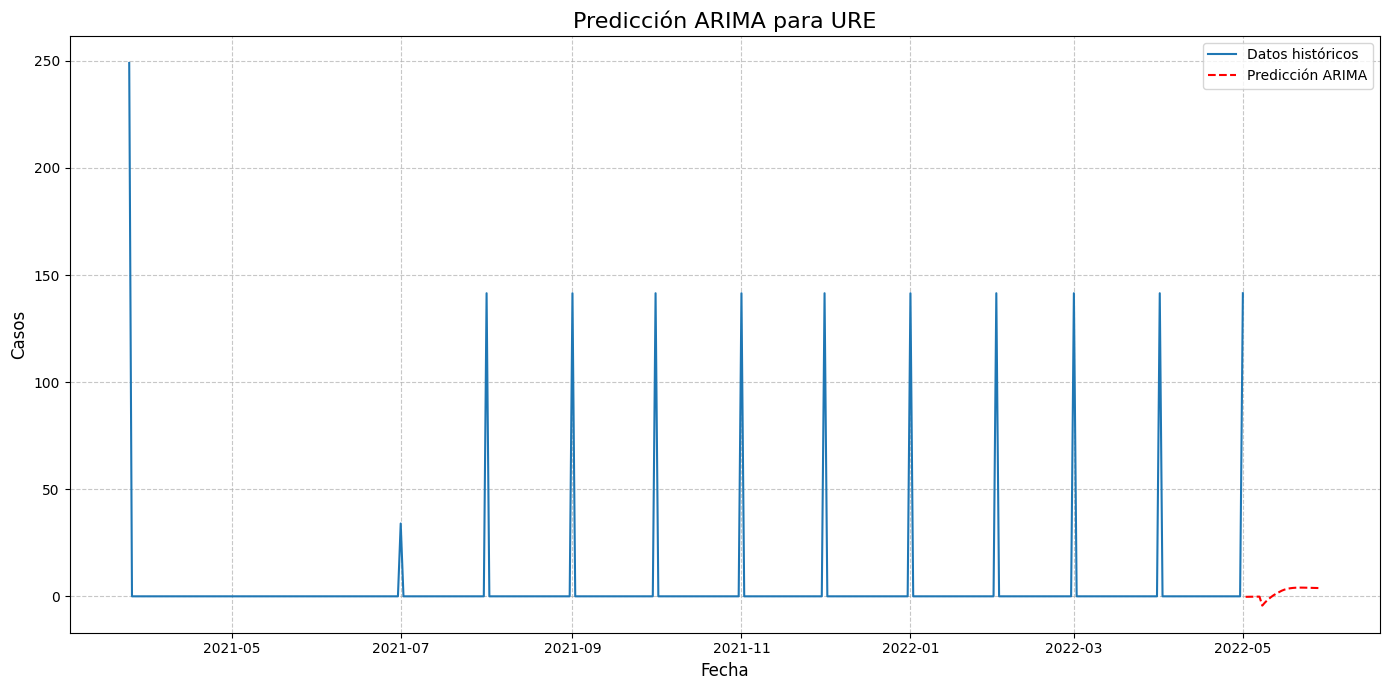

In [32]:
# Ejemplo para una región específica (puedes generalizarlo)
region_ejemplo = "URE"

region_data = df[df['Región'] == region_ejemplo].set_index('Fecha inicio').resample('D').sum()

# Check if region_data is empty or 'Cantidad' column is empty
if region_data.empty or region_data['Cantidad'].empty:
    print(f"No data found for region: {region_ejemplo}")
else:
    # Modelo ARIMA
    model = ARIMA(region_data['Cantidad'], order=(7, 0, 1))
    model_fit = model.fit()

    # Predicción
    forecast = model_fit.forecast(steps=28)
    forecast_dates = pd.date_range(start=region_data.index[-1] + pd.Timedelta(days=1), periods=28)

    # Visualización
    plt.figure(figsize=(14, 7))
    plt.plot(region_data.index, region_data['Cantidad'], label='Datos históricos')
    plt.plot(forecast_dates, forecast, label='Predicción ARIMA', color='red', linestyle='--')
    plt.title(f'Predicción ARIMA para {region_ejemplo}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Casos', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()